# BACKTEST EventDriven

In [4]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from data_source.alpha_vantage_download import AlphaVantageDownload as Downloader# out custom function to download data
import tpot # for machine learning pipeline
import datetime
from data_source.resolution import Resolution
import os

### Configure Backtest

In [123]:
SYMBOL = 'BBVA.MC'
START_BACKTEST = datetime.datetime(2017, 1, 1)
RESOLUTION = Resolution.one_day
LOOKBACK_BARS=5
OPEN_TO_CLOSE = True

### Download Data

In [5]:
startSTR = datetime.datetime.strftime(START_BACKTEST,'%Y%m%d')
tempFile = '%s_%s_%s.csv'%(SYMBOL,startSTR,RESOLUTION)
if not os.path.exists(tempFile):
    data = Downloader().download(symbol='BBVA.MC',start=datetime.datetime(2017, 1, 1),resolution=Resolution.one_day)
    data.to_csv(tempFile)
else:
    data = pd.DataFrame.from_csv(tempFile)

data_source\alpha_vantage_download.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  output['symbol'] = symbol


In [6]:
data.head()

,symbol,open,high,low,close,volume
index,,,,,,
2017-01-02,BBVA.MC,6.459,6.474,6.374,6.0952,19607737.0
2017-01-03,BBVA.MC,6.480,6.686,6.452,6.2135,160332414.0
2017-01-04,BBVA.MC,6.585,6.601,6.434,6.1472,179333129.0
2017-01-05,BBVA.MC,6.463,6.554,6.437,6.1690,144550880.0
2017-01-06,BBVA.MC,6.530,6.578,6.454,6.2144,113930823.0


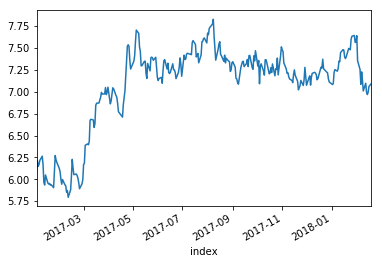

In [7]:
data['close'].plot()

### Machine learning training

In [124]:
## get input and target methods
def getInputData(dataframe,lookback_bars=5):
    output = pd.DataFrame(dataframe['close'])
    for i in range(lookback_bars):
        if i == 0:
            output['close'] = np.log(dataframe['close'])
            output['volume'] = dataframe['volume'].diff()
        else:
            output['diff_%i' % i] = dataframe['close'] - dataframe['close'].shift(i)

    return output.fillna(0).as_matrix()

def getTargetData(dataframe):
    future_return = pd.DataFrame(dataframe['close'])
    if OPEN_TO_CLOSE:
        future_return = (dataframe['close']-dataframe['open']).shift(-1)
    else:
        future_return = future_return.diff().shift(-2)#will buy next close => predict next two
        
    return (future_return > 0).fillna(0).astype(int).values.ravel()



In [125]:
inputData = getInputData(data,LOOKBACK_BARS)
targetData = getTargetData(data)

# haciendo trampas => train set = backtestSet
X_train=inputData
X_test =inputData
y_train=targetData
y_test = targetData


#sin hacer trampas => dividir set en training + backtest test
#X_train, X_test, y_train, y_test = train_test_split(inputData, targetData, test_size=0.33, random_state=42)
# data=data[X_test.index:]

In [126]:
#Using TPOT https://github.com/EpistasisLab/tpot
# TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.
from tpot import TPOTClassifier
mlObject = TPOTClassifier(generations=5,population_size=50,verbosity=2,n_jobs=1)
mlObject.fit(X_train,y_train)

print('TrainScore: %f'%mlObject.score(X_train, y_train))
print('TestScore: %f '%mlObject.score(X_test, y_test))


Version 0.8.3 of tpot is outdated. Version 0.9.2 was released Wednesday January 17, 2018.


Generation 1 - Current best internal CV score: 0.789689009197


Generation 2 - Current best internal CV score: 0.789689009197


Generation 3 - Current best internal CV score: 0.789689009197


Generation 4 - Current best internal CV score: 0.789689009197


Generation 5 - Current best internal CV score: 0.789689009197



Best pipeline: LinearSVC(input_matrix, LinearSVC__C=0.01, LinearSVC__dual=False, LinearSVC__loss=DEFAULT, LinearSVC__penalty=l1, LinearSVC__tol=0.01)
TrainScore: 0.789655
TestScore: 0.789655 


In [127]:
def backtest_eventDriven(data,lookback_bars=5):
    import time
    start_time = time.clock()
    #Iterates each day of data
    output = data.copy()
    output['prediction']=0
    output['position']=0
    last_position = 0
    for index, row in data.iterrows():            
        dataToday = pd.DataFrame(data[:index])
        if len(dataToday)<lookback_bars:
            continue
        inputData = getInputData(dataToday)        
        prediction = mlObject.predict(inputData)
        last_prediction = prediction[-1]
        output['prediction'][index]= last_prediction
        output['position'][index]= last_prediction
        if last_prediction==1 and last_position==0:
#             print 'BUY at %s'%index
            last_position=1
            open_previously=True
            ## sendOrder()
            
        elif last_prediction==0 and last_position==1:
#             print 'close BUY at %s'%index
            last_position=0
            ## closeTrade()
        
#         else:
#             print 'dont do nothing at %s'%index
            
    
    
    end_time = time.clock()
    print('backtest_eventDriven took %i seconds'%(end_time-start_time))
    return output

In [128]:
def backtest_vectorized(data,lookback_bars=5):
    import time
    start_time = time.clock()
    #vectorized
    output = data.copy()
    output['prediction']=0
    output['position']=0
    last_position = 0    
    inputData = getInputData(data)  
    prediction = mlObject.predict(inputData)
    output['prediction'] = prediction
    output['prediction'][:lookback_bars-1]=0
    output['position'] =  output['prediction']
    end_time = time.clock()
    print('backtest_eventDriven took %i seconds'%(end_time-start_time))
    return output

In [129]:
def getBacktestResults(data_position):
    data_position_result = data_position.copy()
    if OPEN_TO_CLOSE:
        data_position_result['returns'] = (data_position['close']-data_position['open']).shift(-1)
    else:
        data_position_result['returns'] = (data_position['close'].diff()).shift(-2)
        
    data_position_result['buy_and_hold'] = data_position_result['close'].diff().cumsum()
    data_position_result['pnl'] = data_position_result['returns']*data_position_result['position']
    data_position_result['equity']=data_position_result['pnl'].cumsum()
    return data_position_result

### Event Driven Backtest

In [ ]:
data_position_ed = backtest_eventDriven(data,lookback_bars=LOOKBACK_BARS)

data_position_ed.head(15)

C:\Users\XE61374\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\XE61374\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
data_backtest_ed = getBacktestResults(data_position_ed)

data_backtest_ed[['equity','buy_and_hold']].plot()

In [ ]:
print 'Final Equity at %s is %.3f'%(data_backtest_vectorized.index[-2],data_backtest_vectorized['equity'][-2])

### Vectorized Backtest

In [101]:
data_position_vector = backtest_vectorized(data,lookback_bars=LOOKBACK_BARS)
data_position_vector.head(15)

C:\Users\XE61374\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


backtest_eventDriven took 0 seconds


,symbol,open,high,low,close,volume,prediction,position
index,,,,,,,,
2017-01-02,BBVA.MC,6.459,6.474,6.374,6.0952,19607737.0,0,0
2017-01-03,BBVA.MC,6.480,6.686,6.452,6.2135,160332414.0,0,0
2017-01-04,BBVA.MC,6.585,6.601,6.434,6.1472,179333129.0,0,0
2017-01-05,BBVA.MC,6.463,6.554,6.437,6.1690,144550880.0,0,0
2017-01-06,BBVA.MC,6.530,6.578,6.454,6.2144,113930823.0,1,1
2017-01-09,BBVA.MC,6.585,6.589,6.470,6.2633,33421900.0,0,0
2017-01-10,BBVA.MC,6.464,6.464,6.344,6.1663,98132610.0,1,1
2017-01-11,BBVA.MC,6.330,6.330,6.121,5.9645,96047571.0,0,0
2017-01-12,BBVA.MC,6.100,6.218,6.035,5.9345,31491231.0,1,1


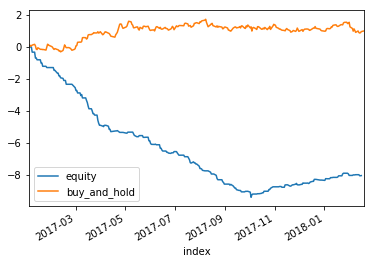

In [102]:
data_backtest_vectorized = getBacktestResults(data_position_vector)

data_backtest_vectorized[['equity','buy_and_hold']].plot()

In [105]:
print 'Final Equity at %s is %.3f'%(data_backtest_vectorized.index[-2],data_backtest_vectorized['equity'][-2])

Final Equity at 2018-02-16 00:00:00 is -8.032
